# リザバーによる異常検知
一定時間の時系列情報から次サンプルを予測させることで，予測との誤差から異常を検知する

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

## データをセグメント化

In [2]:
def segdata(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) #セグメントの切り出し，時系列反転，appendのための2次ベクトル化
        emb = np.append( emb, tmp, axis=0)
    return emb

## データ読み込み　トレーニング，テストデータ分割

In [3]:
!wget "www.dropbox.com/s/x3fmb9mxr4xkip3/qtdbsel102.txt"

--2020-12-09 12:53:22--  http://www.dropbox.com/s/x3fmb9mxr4xkip3/qtdbsel102.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.dropbox.com/s/x3fmb9mxr4xkip3/qtdbsel102.txt [following]
--2020-12-09 12:53:22--  https://www.dropbox.com/s/x3fmb9mxr4xkip3/qtdbsel102.txt
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x3fmb9mxr4xkip3/qtdbsel102.txt [following]
--2020-12-09 12:53:22--  https://www.dropbox.com/s/raw/x3fmb9mxr4xkip3/qtdbsel102.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0bef54e117fd80d51945309fbf.dl.dropboxusercontent.com/cd/0/inline/BEsTzR-4q2dqVxyA56b5RAdpt0pce4VRWWwLIWA9eDZUiAM4DoVsXT8xMW

In [4]:
LEN=3000  #分析区間
WLEN=200 #セグメントのサイズ
SP=0         #学習用データの開始点
AP=3000   #テスト用データの開始点　個のデータの場合 4250ポイント付近に異常がある
data = np.loadtxt("qtdbsel102.txt",delimiter="\t")

#元データは3次元の時系列，3次のデータ(indexとしては2)を指定して学習/テストデータに分割
train_org = data[SP:SP+LEN, 2] -np.mean(data[SP:SP+LEN, 2])     #学習用データとして 1～2999サンプル区間を使用
test_org  = data[AP:AP+LEN, 2] -np.mean( data[AP:AP+LEN, 2]) #テスト用データとして3000～5999サンプルを使用

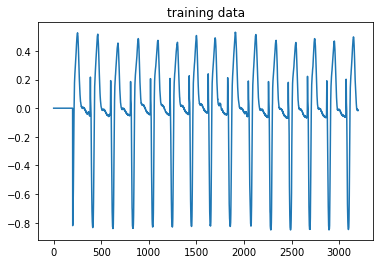

[]

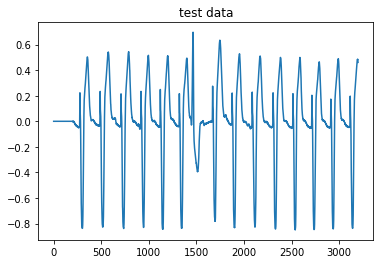

In [5]:
seglen = WLEN   #Window size
#winlenの単位で1ポイントずつずらした2次元表現に変換

train_org=np.append(np.zeros(WLEN),train_org/max(abs(train_org))*0.85)
test_org=np.append(np.zeros(WLEN),test_org/max(abs(test_org))*0.85)

input_v= segdata(train_org, seglen)
output_v= input_v.T[0][1:].T
input_v=input_v[:-1]

plt.plot(train_org)
plt.title("training data")
plt.show()
r_input_v=segdata(test_org,seglen)
r_output_v= r_input_v.T[0][1:].T
plt.plot(test_org)
plt.title("test data")
plt.plot()

In [6]:
class ReservoirNetWork:

    def __init__(self, inputs, outputs,num_input_nodes, num_reservoir_nodes, num_output_nodes, leak_rate=0.1, activator=np.tanh):
        self.inputs = inputs # 学習で使う入力
        self.outputs= outputs
        self.log_reservoir_nodes = np.array([np.zeros(num_reservoir_nodes)]) # reservoir層のノードの状態を記録
        self.current_state =  np.array([np.zeros(num_reservoir_nodes)]) 
        
        # init weights
        self.weights_input = self._generate_variational_weights(num_input_nodes, num_reservoir_nodes)#入力重み
        self.weights_reservoir = self._generate_reservoir_weights(num_reservoir_nodes)#リザバー内重み
        self.weights_output = np.zeros([num_reservoir_nodes, num_output_nodes])#出力重み
        self.delta = np.zeros([num_reservoir_nodes, num_output_nodes])#出力重み

        # それぞれの層のノードの数
        self.num_input_nodes = num_input_nodes
        self.num_reservoir_nodes = num_reservoir_nodes
        self.num_output_nodes = num_output_nodes

        self.leak_rate = leak_rate # 漏れ率
        self.activator = activator # 活性化関数

    # reservoir層のノードの次の状態を取得
    def _get_next_reservoir_nodes(self, input, current_state):
        next_state = (1 - self.leak_rate) * current_state
        #next_state += self.leak_rate * (np.array([input]) @ self.weights_input)
        next_state += self.leak_rate * (np.array(input) @ self.weights_input+ current_state @ self.weights_reservoir)
        return self.activator(next_state)

    # 出力層の重みを更新
    def _update_weights_output(self, lambda0):
        # Ridge Regression
        E_lambda0 = np.identity(self.num_reservoir_nodes) * lambda0 # lambda0　単位行列*lambda0の行列
        inv_x = np.linalg.inv(self.log_reservoir_nodes.T @ self.log_reservoir_nodes + E_lambda0) #逆行列
        # update weights of output layer
        self.weights_output = (inv_x @ self.log_reservoir_nodes.T) @ self.outputs# ここでのinputsは出力として　実際には別にする

        
    def _gen_internal_seq(self):
        self.log_reservoir_nodes = np.array([np.zeros(self.num_reservoir_nodes)]) # reservoir層のノードの状態を記録
        for ainput in self.inputs:#入力の各点が入るたびに内部状態を記録する
            current_state = np.array(self.log_reservoir_nodes[-1])#logの末端の状態が最新（現在）の状態
            self.log_reservoir_nodes = np.append(self.log_reservoir_nodes,
                [self._get_next_reservoir_nodes(ainput, current_state)], axis=0)#次状態をlogに追加
        self.log_reservoir_nodes = self.log_reservoir_nodes[1:]# 最初の0で埋めた分を取り除く
        ##ここで内部状態のすべての変化がトレースできている
        
    # 学習する（リッジ回帰版）
    def train(self, lambda0=0.1):
        self._gen_internal_seq()
        self._update_weights_output(lambda0)#重みを更新

    def get_weight(self):
        return self.weights_output
    
    # 学習で得られた重みを基に訓練データを学習できているかを出力
    def get_train_result(self):
        outputs = []
        reservoir_nodes = np.zeros(self.num_reservoir_nodes)
        for input in self.inputs:
            reservoir_nodes = self._get_next_reservoir_nodes(input, reservoir_nodes)
            outputs.append(self.get_output(reservoir_nodes))
        return outputs

    def predict(self, unknowninput, lambda0=0.01):
        predicted_outputs = np.array([0]) #初期出力０
        reservoir_nodes = self.log_reservoir_nodes[0] # 訓練の結果得た最後の内部状態を取得する場合は[-1] 完全に初期状態は[0]
        
        # １つづつ入力を取り出して予測
        for inp in unknowninput:
            reservoir_nodes = self._get_next_reservoir_nodes(inp, reservoir_nodes)#入力を入れて次状態を得る
            predicted_outputs=np.append(predicted_outputs,self.get_output(reservoir_nodes))#次状態から出力を得てバッファにappend
        return predicted_outputs[1:] # 最初に使用した学習データ以降が予測値


    # get output of current state
    def get_output(self, reservoir_nodes):
        return self.activator(reservoir_nodes @ self.weights_output) #修正前
        #return reservoir_nodes @ self.weights_output # 修正後

    #############################
    ##### private method ########
    #############################

    # 重みを0.1か-0.1で初期化したものを返す
    def _generate_variational_weights(self, num_pre_nodes, num_post_nodes):
        return (np.random.randint(0, 2, num_pre_nodes * num_post_nodes).reshape([num_pre_nodes, num_post_nodes]) * 2 - 1) * 0.1

    # Reservoir層の重みを初期化
    def _generate_reservoir_weights(self, num_nodes):
        weights = np.random.normal(0, 1, num_nodes * num_nodes).reshape([num_nodes, num_nodes])
        spectral_radius = max(abs(linalg.eigvals(weights)))
        return weights / spectral_radius

## 学習データでリザバーをトレーニング

In [7]:
model = ReservoirNetWork(inputs=input_v,#入力（1次ベクトル）
                         outputs=output_v,  #ターゲット（未来のイベント）
                         num_input_nodes=WLEN,        #入力ノード数 
                         num_reservoir_nodes=150,       #リザバーノード数 
                         num_output_nodes=1,            #出力ノード数
                         leak_rate=0.01)
model.train()

## 学習データの予測

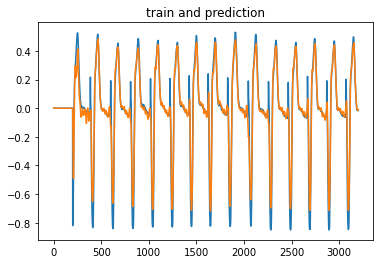

In [8]:
train_ret=model.predict(input_v)
plt.plot(train_org)
plt.plot(np.append(np.zeros(WLEN),train_ret))
plt.title("train and prediction")
plt.show()
diff_train=train_org-np.append(np.zeros(WLEN),train_ret)

## テストデータ（異常を含む）の予測

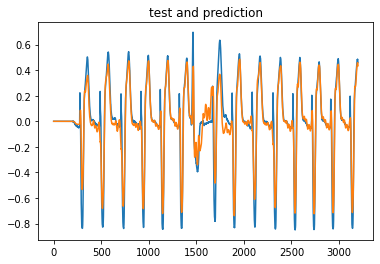

In [10]:
test_ret=model.predict(r_input_v)
plt.plot(test_org)
plt.plot(np.append(np.zeros(WLEN),test_ret))
plt.title("test and prediction")
plt.show()
diff_test=test_org-np.append(np.zeros(WLEN),test_ret[:-1])

## 誤差の比較

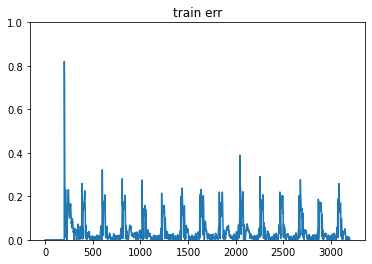

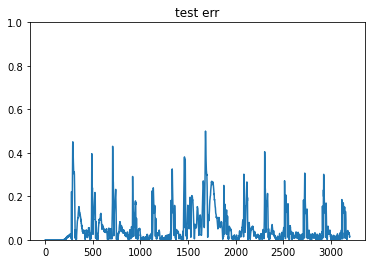

In [11]:
plt.plot(abs(diff_train))
plt.ylim([0,1.0])
plt.title("train err")
plt.show()
plt.plot(abs(diff_test))
plt.title("test err")
plt.ylim([0,1.0])
plt.show()